In [1]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using JuMP
using BARON
using LinearAlgebra
using StaticArrays
using MINLPTrajOpt
using MINLPTrajOpt.SO3
using Rotations
using Random

In [3]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = false;

In [4]:
solver = BaronSolver(threads=Sys.CPU_THREADS, EpsA=1e-2, MaxTime=1 * 60.0, PrTimeFreq=5.)
# solver = CouenneNLSolver()
parameters = SO3Parameters(Ixx = 1., Iyy = 0.7, Izz = 1.4)
# parameters = SO3Parameters()
τmax = 1.0
Random.seed!(1)
quat0 = rand(Quat)
ω0 = zero(SVector{3})

N = 10
T = 1.0
Δt = T / N
Δθmax = 0.3 * 30 / N
# Δθmax = π

problem = SO3Problem(parameters, quat0, ω0, solver; τmax=τmax, Δt=Δt, N=N, Δθmax=Δθmax);

In [5]:
status = solve(problem.model)

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value 0.810117134283     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value 0.417344010233   

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /home/twan/.julia/packages/JuMP/Xvn0n/src/nlp.jl:1283


:UserLimit

In [6]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "so3", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(dirname(problem.model.internalModel.options[:SumName]), joinpath(datadir, "baronfiles"))
end

In [7]:
problem.model.internalModel.options[:SumName]

"/tmp/tmpGc77Cf/sum.lst"

In [8]:
t = range(0, T, length=N+1)
quats = getvalue.(problem.q)
pushfirst!(quats, problem.q0)
θs = map(rotation_angle, quats)
qs = [[quat.w, quat.x, quat.y, quat.z] for quat in quats]
Δquats = getvalue.(problem.Δq)
ωs = getvalue.(problem.ω)
ωds = getvalue.(problem.ωd)
τs = getvalue.(problem.τ);

In [9]:
using Test
for Δquat in Δquats
    Δθ = 2 * acos(Δquat.w)
    @test Δθ <= Δθmax + 1e-6
    @test norm([Δquat.w, Δquat.x, Δquat.y, Δquat.z]) ≈ 1 atol=1e-6
end

In [10]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "T = $T")
        println(io, "τmax = $τmax")
        println(io, "quat0 = $quat0")
        println(io, "ω0 = $ω0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "objective value = $(getobjectivevalue(problem.model))")
        println(io, "objective lower bound = $(getobjbound(problem.model))")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

In [11]:
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras", "PlottingTools"))
using PlottingTools
using PlottingTools.LaTeXStrings
using PlottingTools.PGFPlotsX
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

PDFLATEX::LaTeXEngine = 1

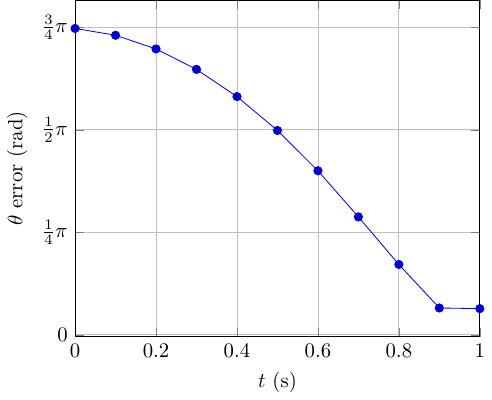

In [12]:
p = timeplot(t, θs; ylabel=L"$\theta$ error (rad)")
piticks!(p, 1//4, θs; axis=:y)
save_data && pgfsave(joinpath(datadir, "error.pdf"), p)
p

In [13]:
using RigidBodyDynamics

In [14]:
world = RigidBody{Float64}("world")
mechanism = Mechanism(world)
joint = Joint("joint", QuaternionSpherical{Float64}())
inertia = SpatialInertia(joint.frame_after, Diagonal([parameters.Ixx, parameters.Iyy, parameters.Izz]), zeros(3), 30.0)
body = RigidBody(inertia)
attach!(mechanism, world, body, joint);

In [15]:
using MeshCat, MeshCatMechanisms, MechanismGeometries, Logging

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/25f9570346b69729e3f0d089746606f6943c897a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/25f9570346b69729e3f0d089746606f6943c897a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [16]:
mvis = MechanismVisualizer(mechanism, Skeleton(inertias=true));
with_logger(NullLogger()) do
    open(mvis)
end;

In [17]:
frame = frame_after(joint)
setobject!(mvis[frame]["triad"], Triad(0.5));

In [18]:
setanimation!(mvis, t, qs);

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #setanimation!#4(::Int64, ::Bool, ::Int64, ::Function, ::MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,QuaternionSpherical{Float64}},1}},1}},Visualizer}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Array{Array{Float64,1},1}) at animate.jl:46
└ @ MeshCatMechanisms /home/twan/.julia/packages/MeshCatMechanisms/AHOtT/src/animate.jl:46
